## Configuration

In [1]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = '/melanoma_distance_100_XX'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/melanoma_distance_100_XX'
motif_size = 4
iterations = 1000
force_run_fanmod = False
force_parse = False

In [2]:
cells_type = {
    0: 'B cell',
    1: 'CD4 APC',
    2: 'CD4 T cell',
    3: 'CD4 Treg',
    4: 'CD8 T cell',
    5: 'DCs',
    6: 'Germinal Center B cell',
    7: 'Hevs',
    8: 'MAC',
    9: 'Memory CD4 T Cell',
    10: 'NK cell',
    11: 'Neutrophil',
    12: 'Stroma',
    13: 'Tumor',
    14: 'Unidentified',
    15: 'Vessels'
}

Distant_metastases_class = {
    'NP': 'NP',
    'NN': 'NN',
    'PN': 'PN',
    'PP': 'PP',
}

class_to_color = {
    'NP': 'green',
    'NN': 'yellow',
    'PN': 'magenta',
    'PP': 'blue',
}

target_classes = ['NN', 'NP']
target_classes_str = 'NN_NP'

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [3]:
from cism.cism import CISM

In [4]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=1, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [5]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                                                tissue_state_to_string=Distant_metastases_class,
                                                common_cells_type=cells_type)

In [6]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NN,20
NP,18
PN,13
PP,17


### Test stability of cell-cell distribution across thresholds


In [6]:
import numpy as np
import networkx as nx

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list,
                                     motifs_weight: pd.DataFrame) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            from cism.helpers import string_base64_pickle
            target_motif = string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += motifs_weight.loc[motif_id]

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 56
group NP size: 100
motif_id: 1180411340, hash_id: 3548506018205411712
motif_id: 10282045932, hash_id: 5504299300613250476
motif_id: 16453356012, hash_id: 1400127824519001724
motif_id: 13504240108, hash_id: 1400127824519001724
motif_id: 15378574828, hash_id: 1400127824519001724
motif_id: 15918060012, hash_id: 1400127824519001724
motif_id: 11581149676, hash_id: 8935360881190759404
motif_id: 10237401580, hash_id: 8935360881190759404
motif_id: 11041664492, hash_id: 8935360881190759404
motif_id: 9165239788, hash_id: 8935360881190759404
motif_id: 12116445676, hash_id: 8935360881190759404
motif_id: 4027650444, hash_id: 4193229141249784460
motif_id: 539032684, hash_id: 4630308491393371987
motif_id: 5925624204, hash_id: -7620974598964967283
motif_id: 5928194188, hash_id: 5079059912701267580
motif_id: 2969695692, hash_id: -7742621829153632813
motif_id: 575272396, hash_id: 709003983248200715
motif_id: 7281472972, hash_id: 6617930147470794940
motif_id: 6746697164, hash_id: 661793

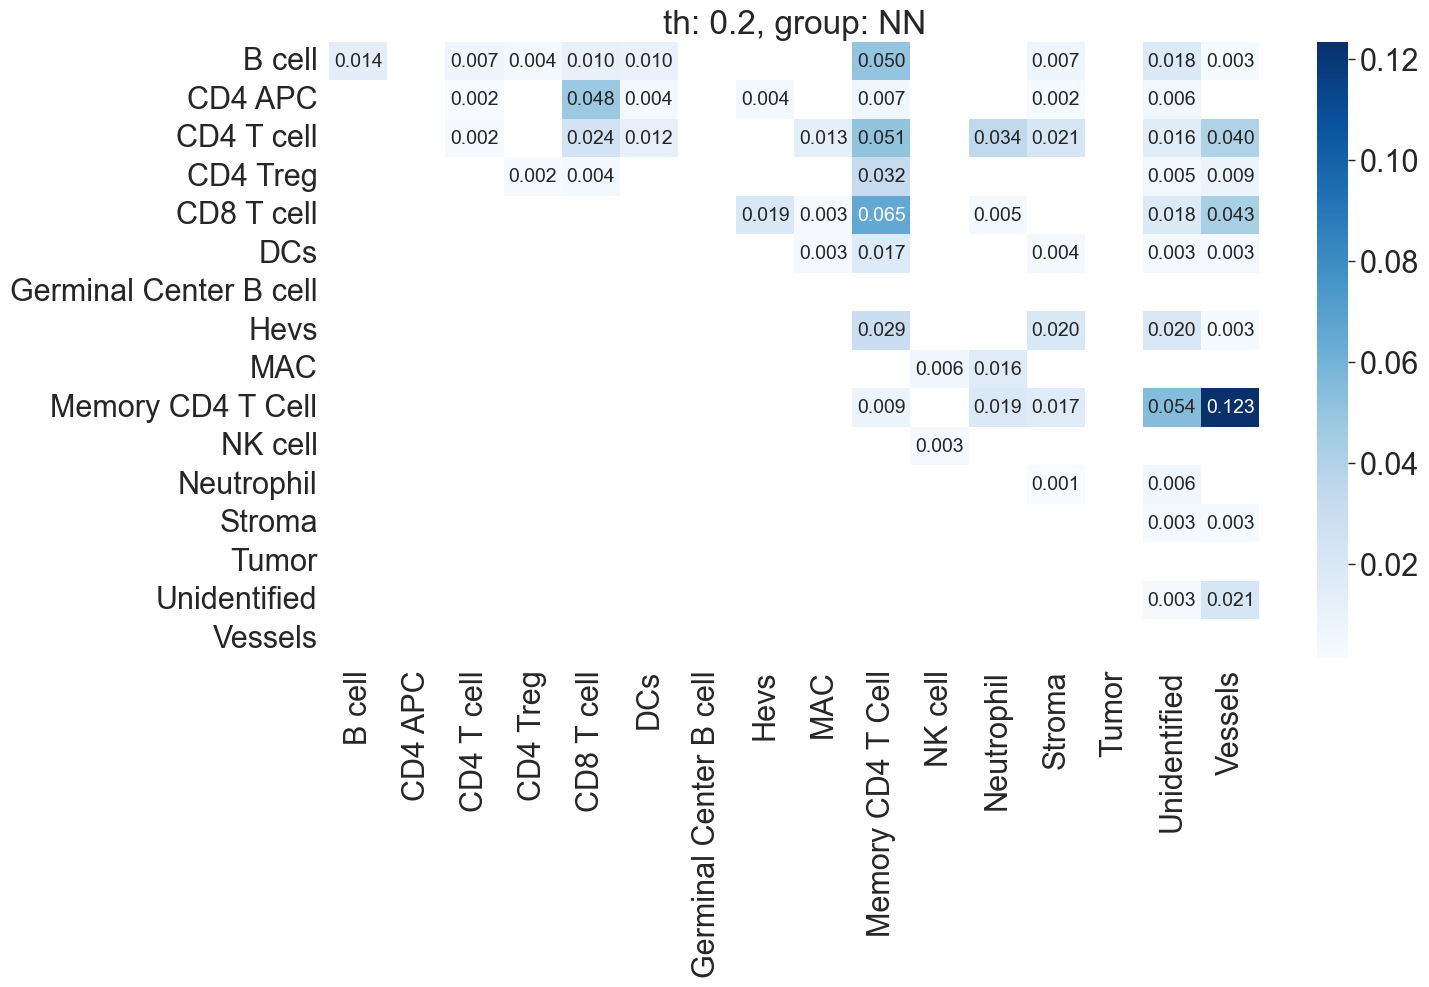

motif_id: 9167247628, hash_id: -660105732125753416
motif_id: 16411330956, hash_id: 6094850151381902528
motif_id: 9738848652, hash_id: -7984719251872030910
motif_id: 10248360396, hash_id: 1536983684886809991
motif_id: 9175669196, hash_id: 1536983684886809991
motif_id: 11589489100, hash_id: 1536983684886809991
motif_id: 3560048940, hash_id: -5553621480106670715
motif_id: 3566446028, hash_id: 6811742873271222022
motif_id: 23946044876, hash_id: 250047831461527356
motif_id: 25016116684, hash_id: 250047831461527356
motif_id: 3501345260, hash_id: 992955305049824090
motif_id: 2429183468, hash_id: 992955305049824090
motif_id: 12131214796, hash_id: 2718946593091548400
motif_id: 2496325068, hash_id: 1815864144058781085
motif_id: 18863542764, hash_id: -4094262317725730701
motif_id: 18328734188, hash_id: 6183121957145879458
motif_id: 12124768460, hash_id: 8299111291565896846
motif_id: 12659544268, hash_id: 8299111291565896846
motif_id: 9170943180, hash_id: 8299111291565896846
motif_id: 12661652684,

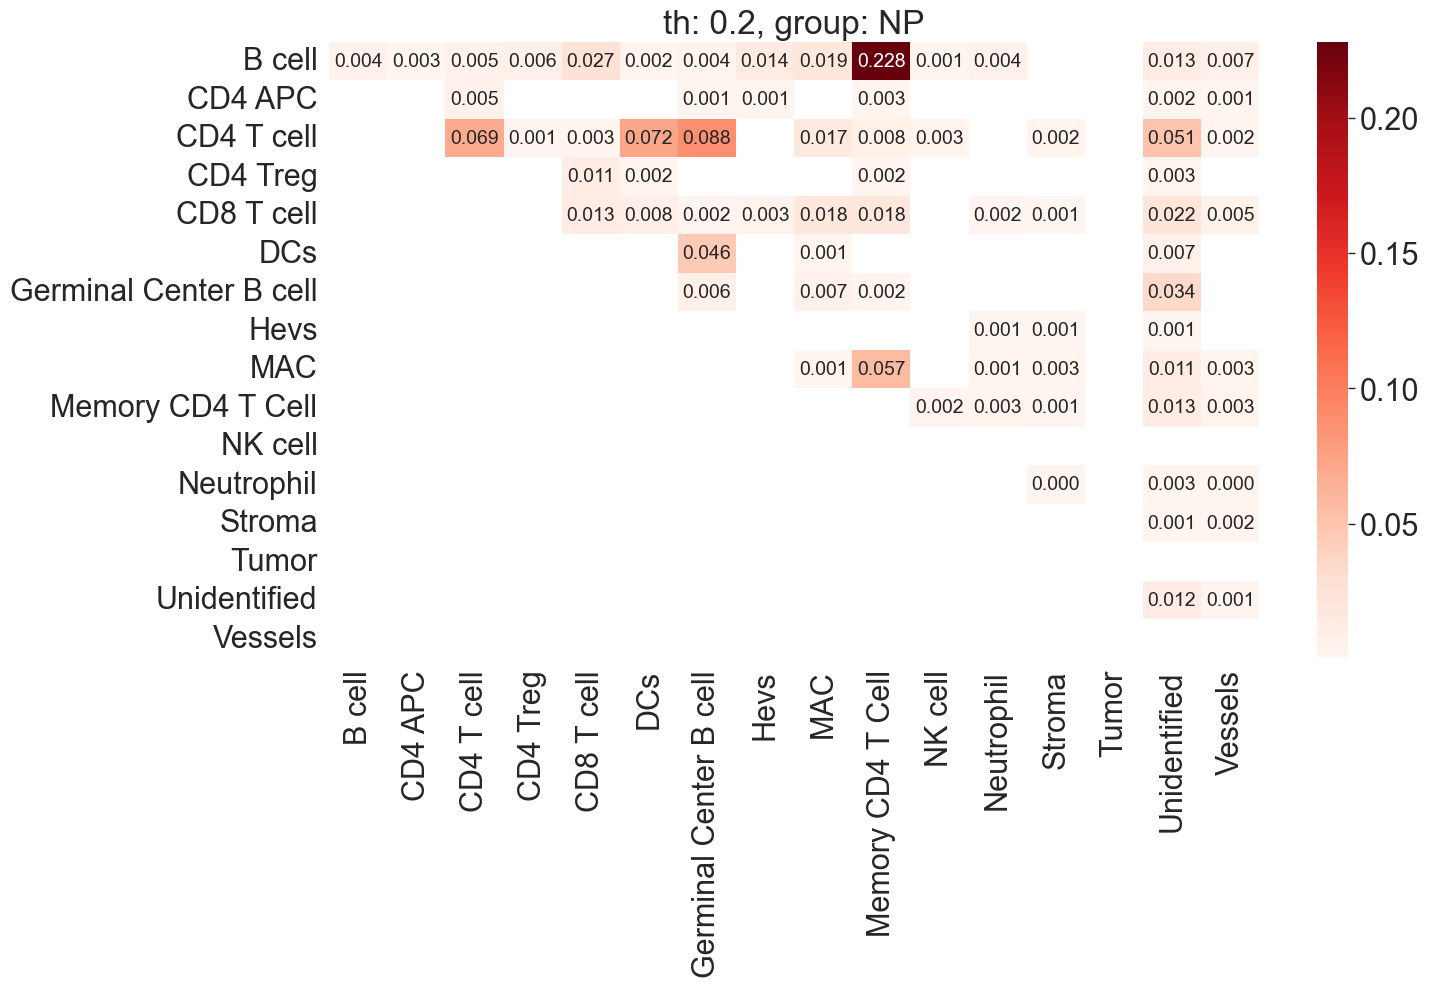

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 49
group NP size: 84
motif_id: 7269339596, hash_id: 8173372064104969799
motif_id: 11581149676, hash_id: 8935360881190759404
motif_id: 11041664492, hash_id: 8935360881190759404
motif_id: 13462215148, hash_id: 1823101890295899706
motif_id: 15918060012, hash_id: 1400127824519001724
motif_id: 5388824012, hash_id: -3783821207252436004
motif_id: 37396624844, hash_id: -2759409616410145012
motif_id: 10231641452, hash_id: 4998471879349489886
motif_id: 2431142124, hash_id: -2923136233108592414
motif_id: 2451664140, hash_id: -6362785185076007102
motif_id: 6749250860, hash_id: -5203036210348590078
motif_id: 7829866796, hash_id: 8930257992075820356
motif_id: 5397179692, hash_id: 8451560770446101120
motif_id: 19644696876, hash_id: 7006577083503962325
motif_id: 19669846348, hash_id: 4092891317731859338
motif_id: 38456704332, hash_id: -8713142649215636994
motif_id: 36040785228, hash_id: -8713142649215636994
motif_id: 20208317932, hash_id: -2575233601865130474
motif_id: 9173710316, hash_

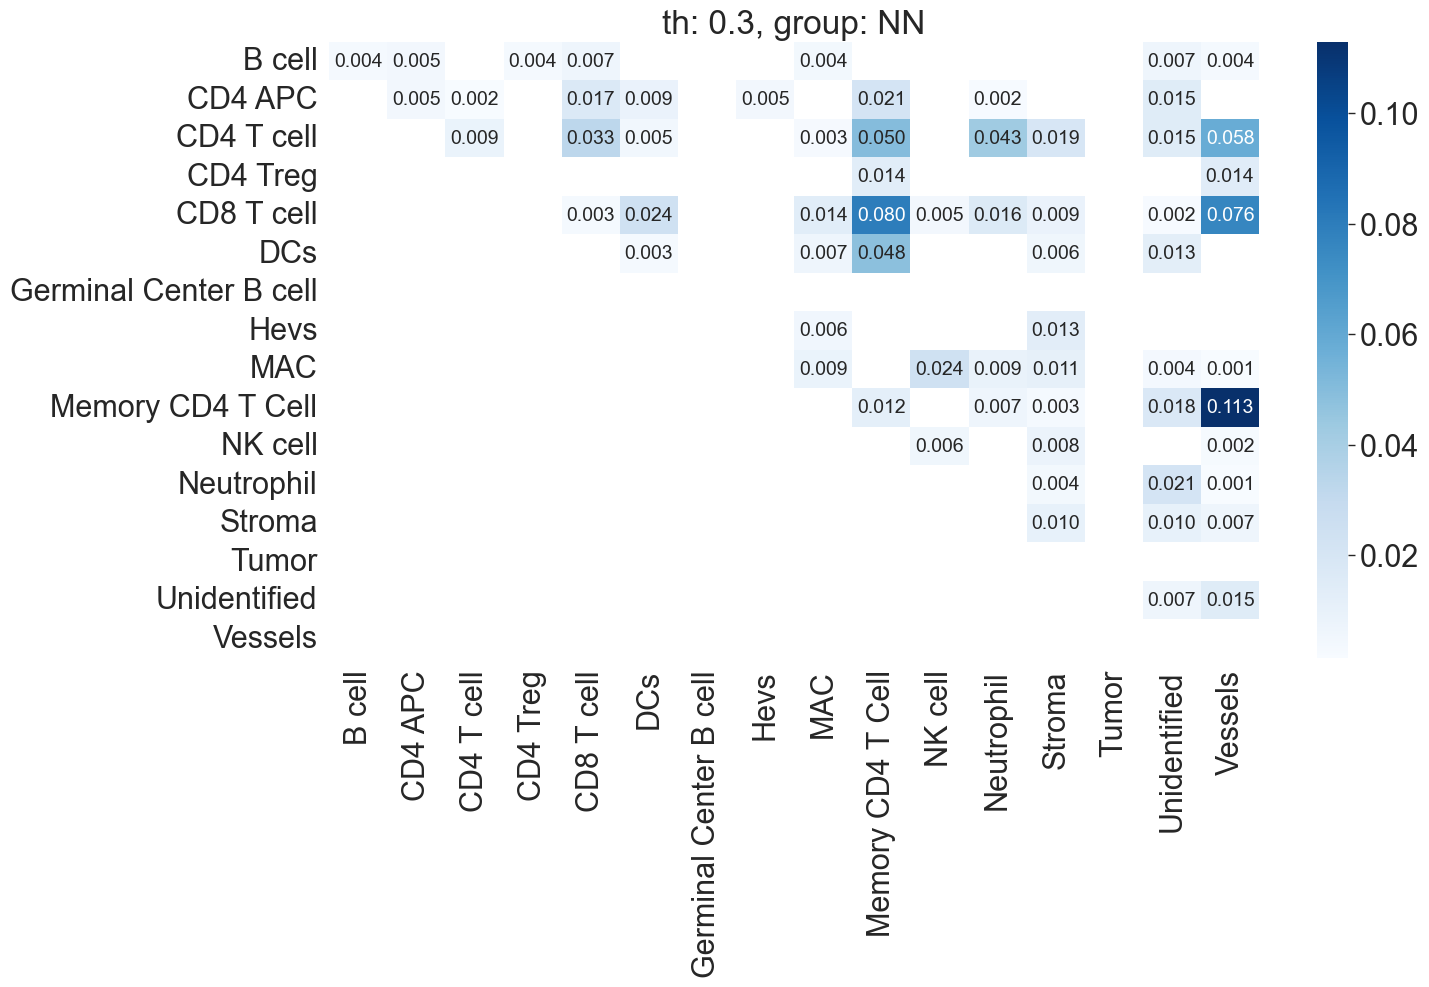

motif_id: 9167247628, hash_id: -660105732125753416
motif_id: 16402942348, hash_id: 2559706041182080051
motif_id: 16939817356, hash_id: 2559706041182080051
motif_id: 9738848652, hash_id: -7984719251872030910
motif_id: 16402958732, hash_id: -1798096907293340332
motif_id: 1115294188, hash_id: -7281305230294004616
motif_id: 16417793484, hash_id: 7779624149145954569
motif_id: 37392945644, hash_id: -8025382871041942634
motif_id: 5391377868, hash_id: 3914887218286053913
motif_id: 5443832300, hash_id: -610278155171468439
motif_id: 19667789260, hash_id: 5034151937619604283
motif_id: 3549586892, hash_id: -4393520322829233331
motif_id: 18863542764, hash_id: -4094262317725730701
motif_id: 16950825452, hash_id: 1823101890295899706
motif_id: 1121641836, hash_id: -6305563230588491547
motif_id: 3539660140, hash_id: -6305563230588491547
motif_id: 3024802188, hash_id: -1844936782012438302
motif_id: 2487936396, hash_id: -1844936782012438302
motif_id: 15901249932, hash_id: -2937209521203962343
motif_id: 3

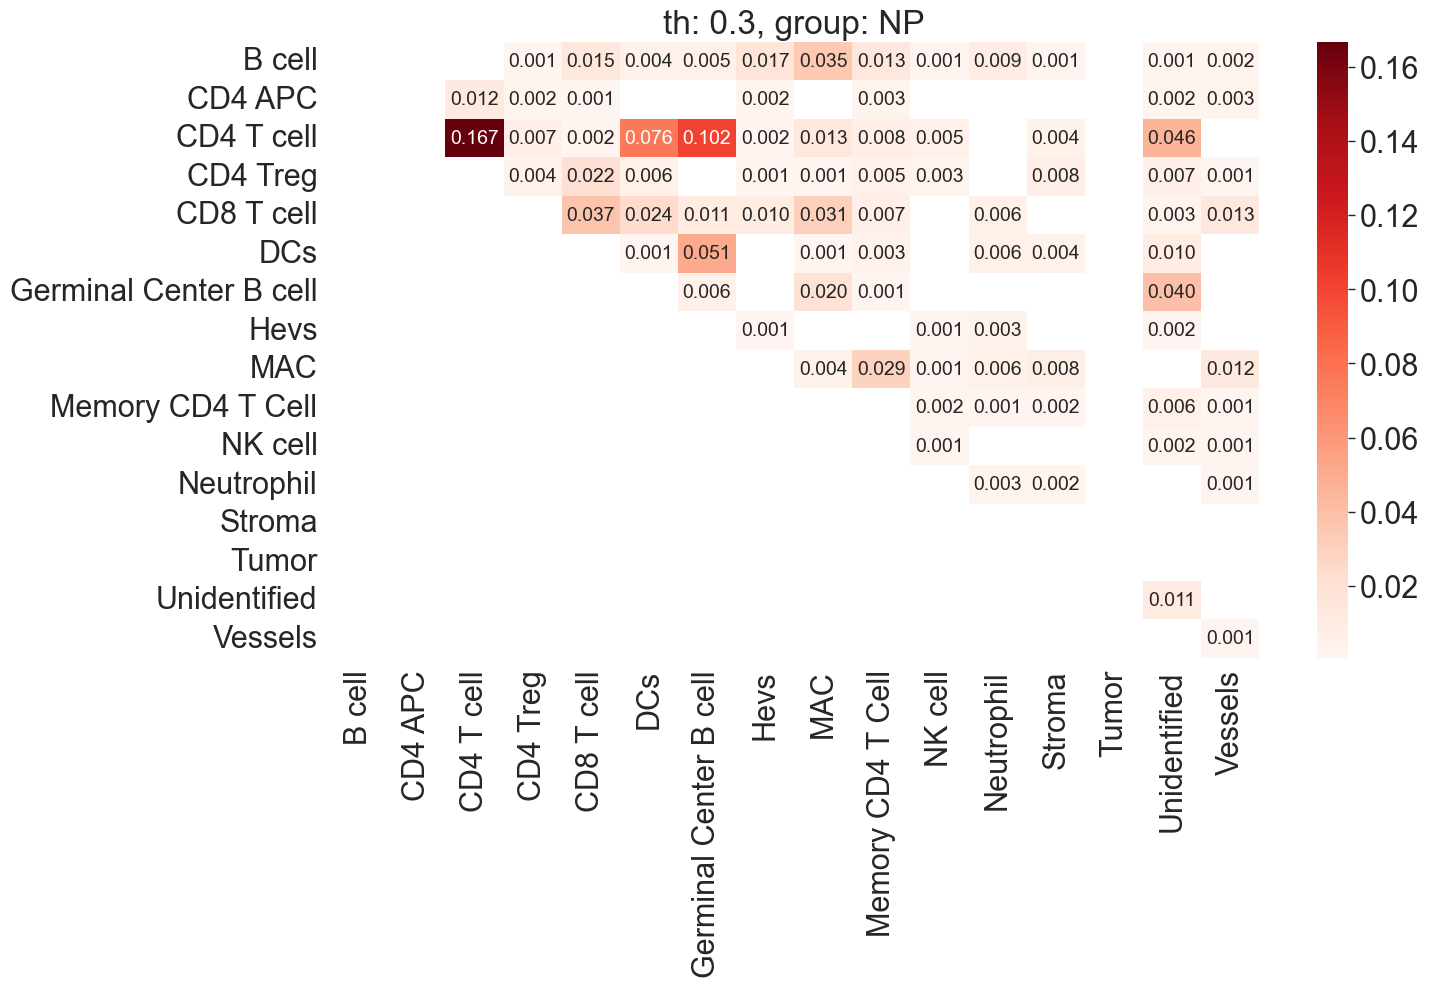

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 16
group NP size: 34
motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 9209314700, hash_id: 2210912591987765047
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 3013754252, hash_id: -8334768063605862937
motif_id: 12121206156, hash_id: -7190262292193738048
motif_id: 4052907340, hash_id: 454950488511191943
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 20748339660, hash_id: 7522159845133462507
motif_id: 11583232364, hash_id: -3798811191137981739
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 17763644908, hash_id: -3945035406512623651
motif_id: 18320387564, hash_id: -7321669116781052540
motif_id: 11583216108, hash_id: -329429234689486903
motif_id: 20208317932, hash_id: -2575233601865130474
motif_id: 7809403244, hash_id: 2292698959359557611


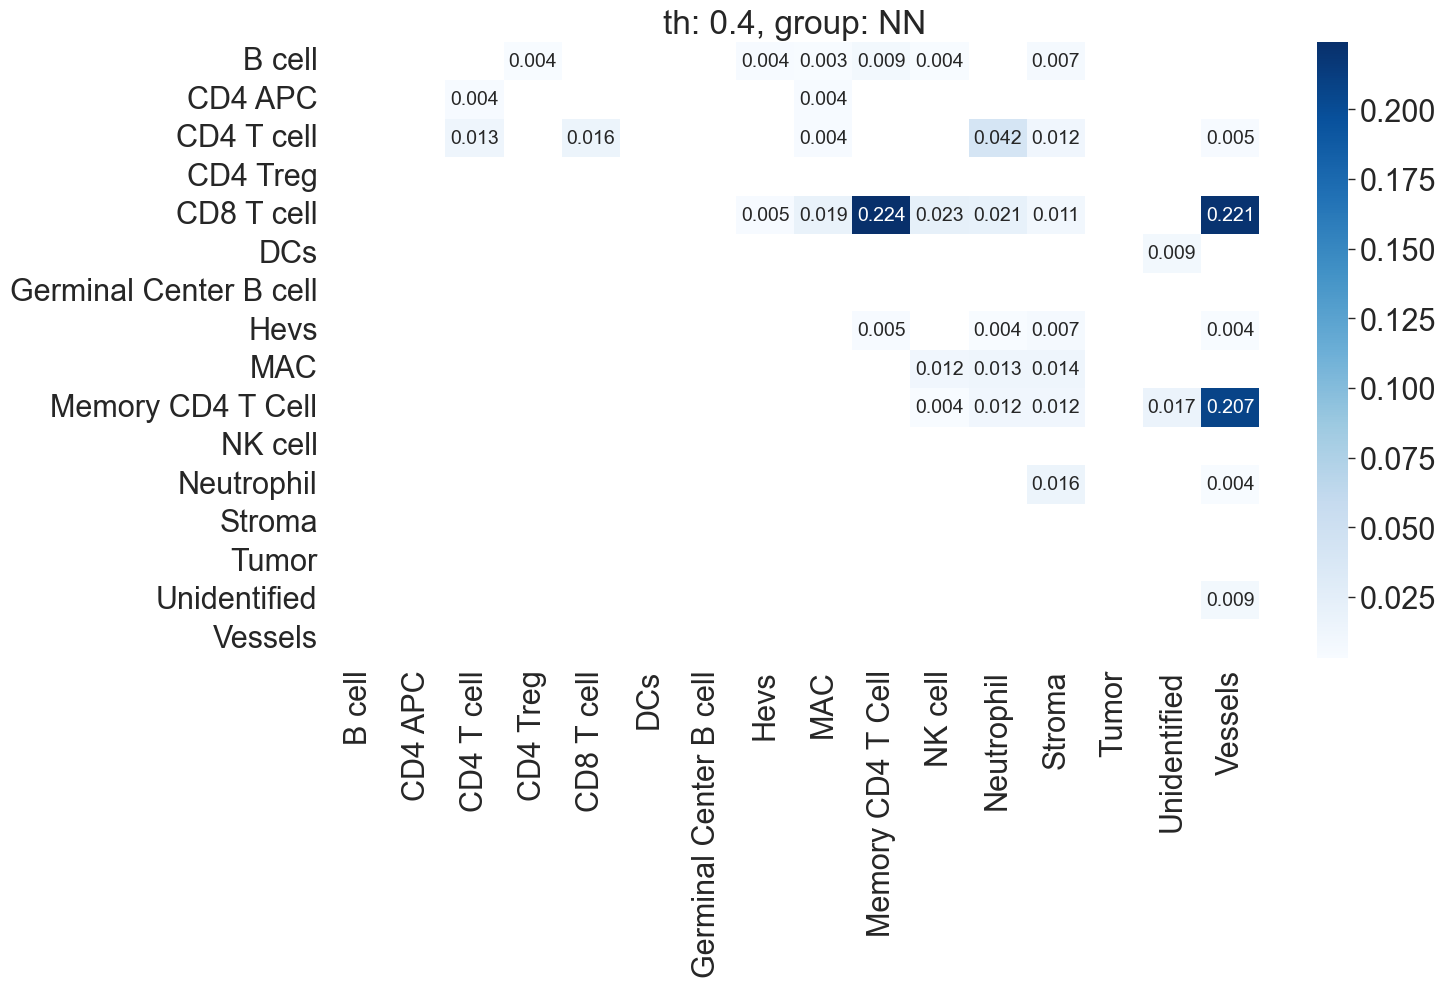

motif_id: 7809321100, hash_id: 6772266359495739224
motif_id: 17786158572, hash_id: -2003530031649075489
motif_id: 16939817356, hash_id: 2559706041182080051
motif_id: 16942445964, hash_id: 2559706041182080051
motif_id: 16956610828, hash_id: -1217979870471410545
motif_id: 12110603532, hash_id: 2856578561211090970
motif_id: 4065949068, hash_id: 2643836404408428104
motif_id: 16944617868, hash_id: 3774511630474819600
motif_id: 3509726668, hash_id: -1659630622589713720
motif_id: 1639021836, hash_id: 7476495471272693903
motif_id: 12097480012, hash_id: -5659898672581499462
motif_id: 5391377868, hash_id: 3914887218286053913
motif_id: 8352511276, hash_id: -9169652306312067512
motif_id: 7275101484, hash_id: -9169652306312067512
motif_id: 34965962028, hash_id: 1161395837192515596
motif_id: 1658451404, hash_id: -3224596876564360443
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 16416058540, hash_id: 1118968396280097033
motif_id: 11075202540, hash_id: -2419085700876409031
motif_id: 15

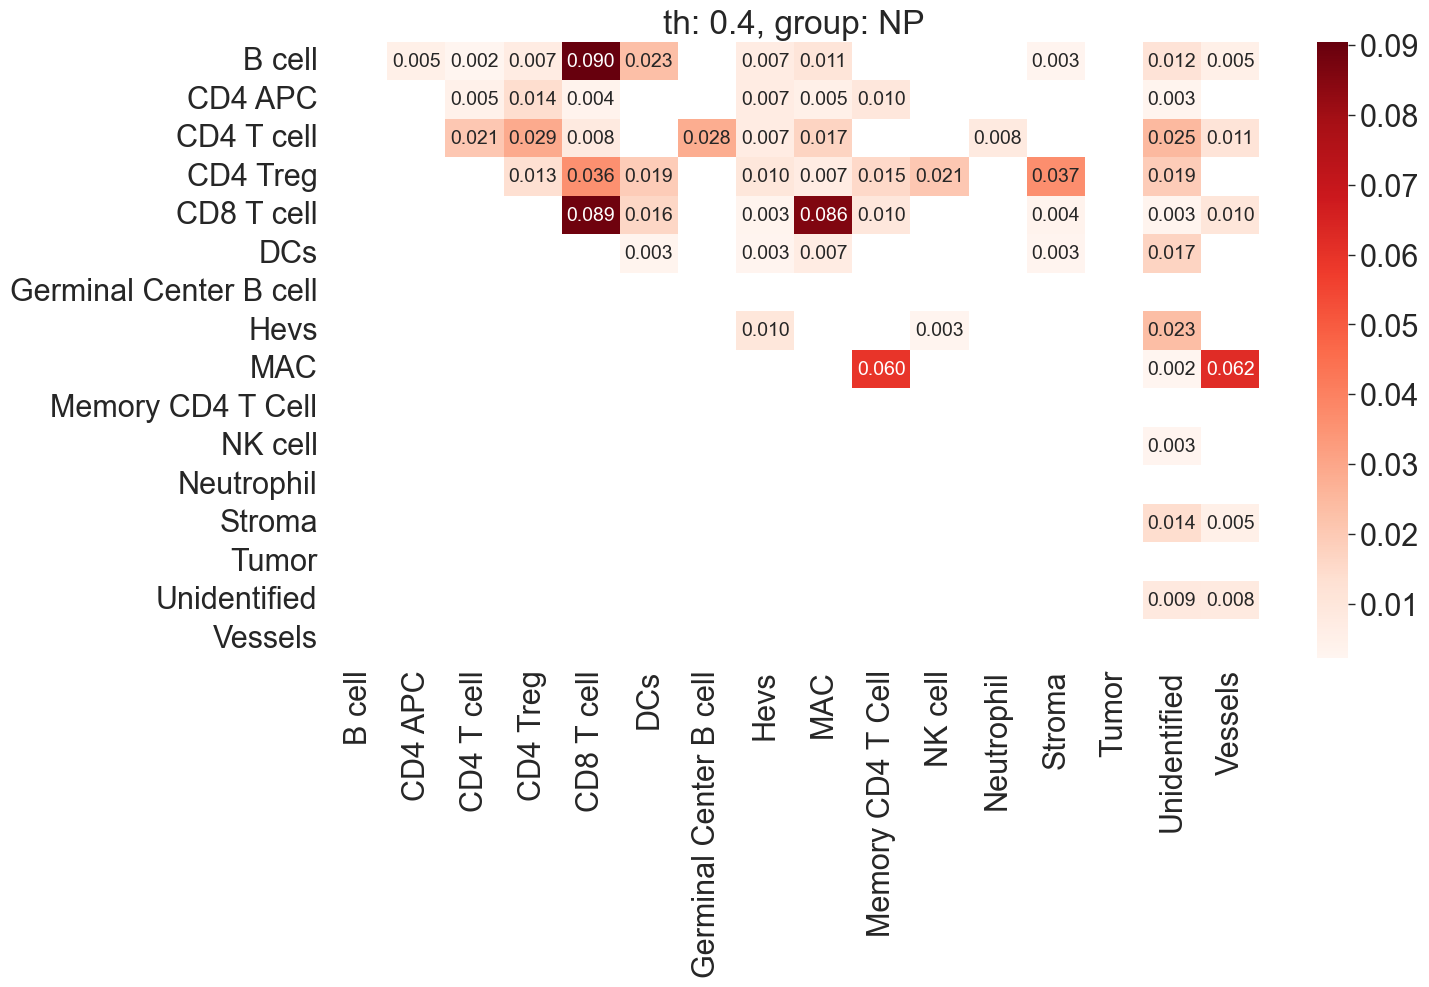

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 16
group NP size: 26
motif_id: 3013754252, hash_id: -8334768063605862937
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 9209314700, hash_id: 2210912591987765047
motif_id: 12121206156, hash_id: -7190262292193738048
motif_id: 4052907340, hash_id: 454950488511191943
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 20748339660, hash_id: 7522159845133462507
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 11583232364, hash_id: -3798811191137981739
motif_id: 7809403244, hash_id: 2292698959359557611
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 17763644908, hash_id: -3945035406512623651
motif_id: 11583216108, hash_id: -329429234689486903
motif_id: 18320387564, hash_id: -7321669116781052540
motif_id: 20208317932, hash_id: -2575233601865130474


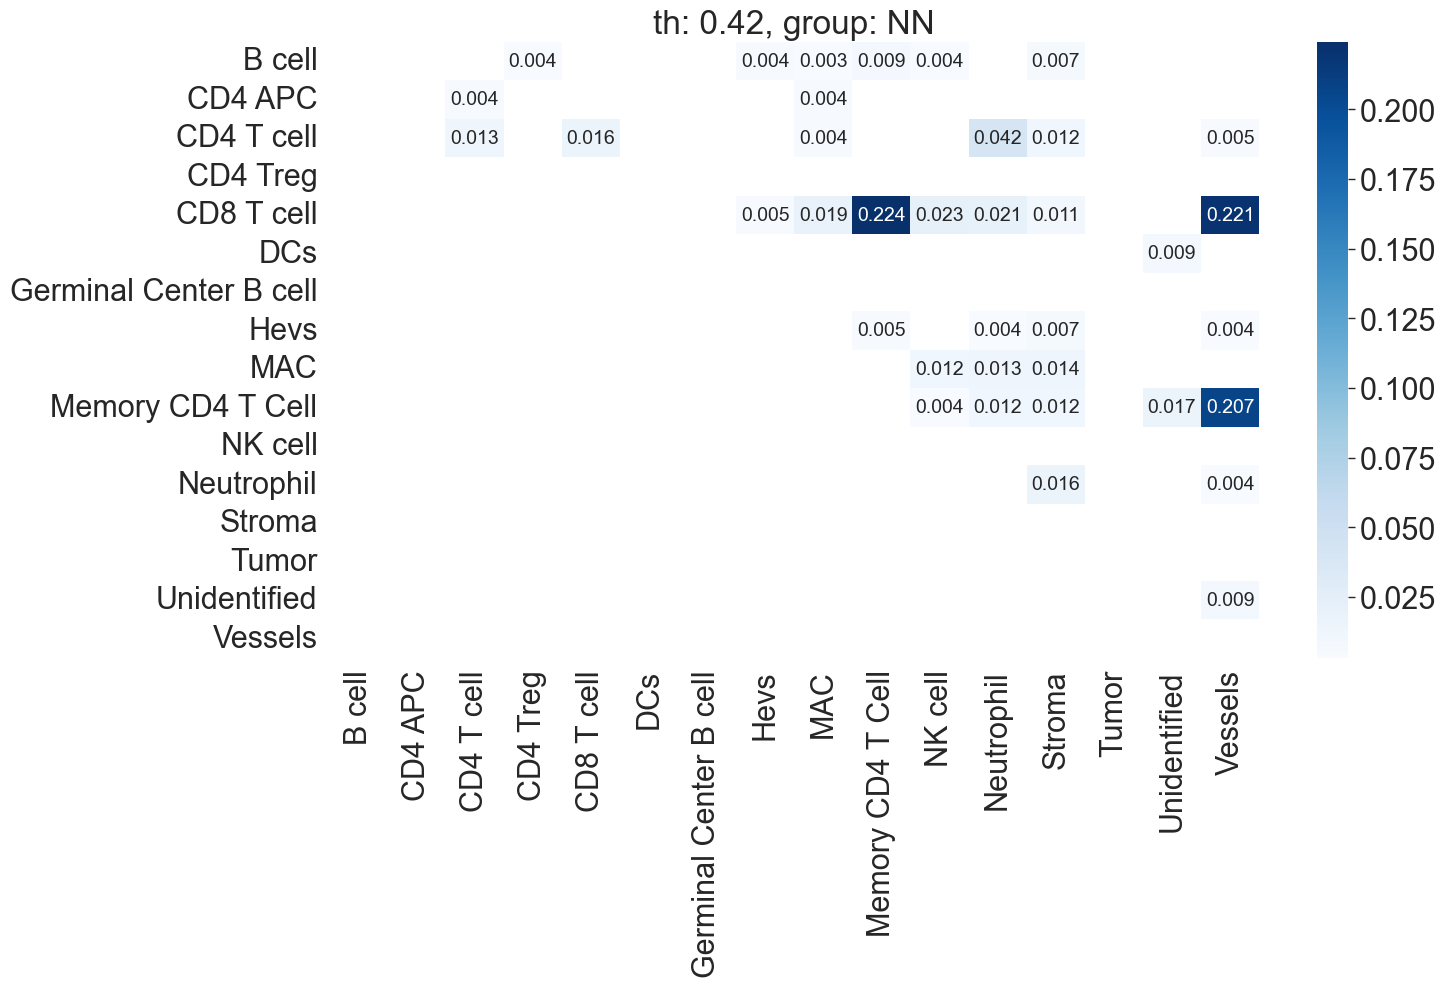

motif_id: 7809321100, hash_id: 6772266359495739224
motif_id: 17786158572, hash_id: -2003530031649075489
motif_id: 16939817356, hash_id: 2559706041182080051
motif_id: 16942445964, hash_id: 2559706041182080051
motif_id: 12110603532, hash_id: 2856578561211090970
motif_id: 4065949068, hash_id: 2643836404408428104
motif_id: 16944617868, hash_id: 3774511630474819600
motif_id: 2454267148, hash_id: -2785496978450312591
motif_id: 1639021836, hash_id: 7476495471272693903
motif_id: 1658451404, hash_id: -3224596876564360443
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 34965962028, hash_id: 1161395837192515596
motif_id: 16416058540, hash_id: 1118968396280097033
motif_id: 15901249932, hash_id: -2937209521203962343
motif_id: 12097480012, hash_id: -5659898672581499462
motif_id: 16417793484, hash_id: 7779624149145954569
motif_id: 3522784716, hash_id: -7428170179511166437
motif_id: 15341317580, hash_id: 6191483428857422447
motif_id: 4880694732, hash_id: 6501729852448164872
motif_id: 539

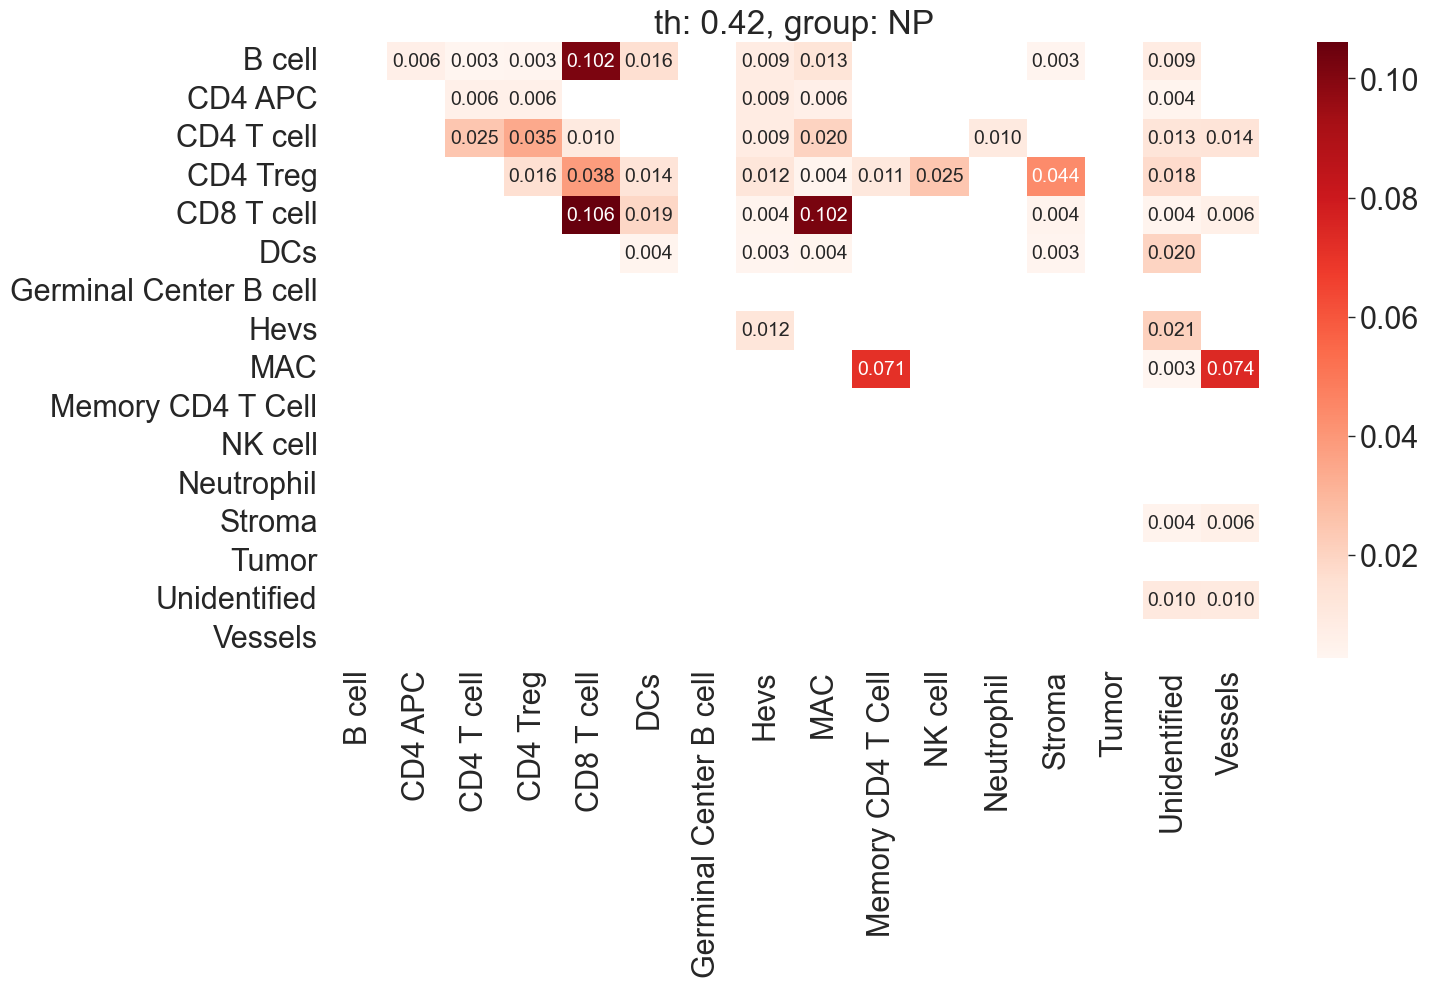

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 13
group NP size: 26
motif_id: 3013754252, hash_id: -8334768063605862937
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 9209314700, hash_id: 2210912591987765047
motif_id: 4052907340, hash_id: 454950488511191943
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 20748339660, hash_id: 7522159845133462507
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 11583232364, hash_id: -3798811191137981739
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 17763644908, hash_id: -3945035406512623651
motif_id: 11583216108, hash_id: -329429234689486903
motif_id: 18320387564, hash_id: -7321669116781052540


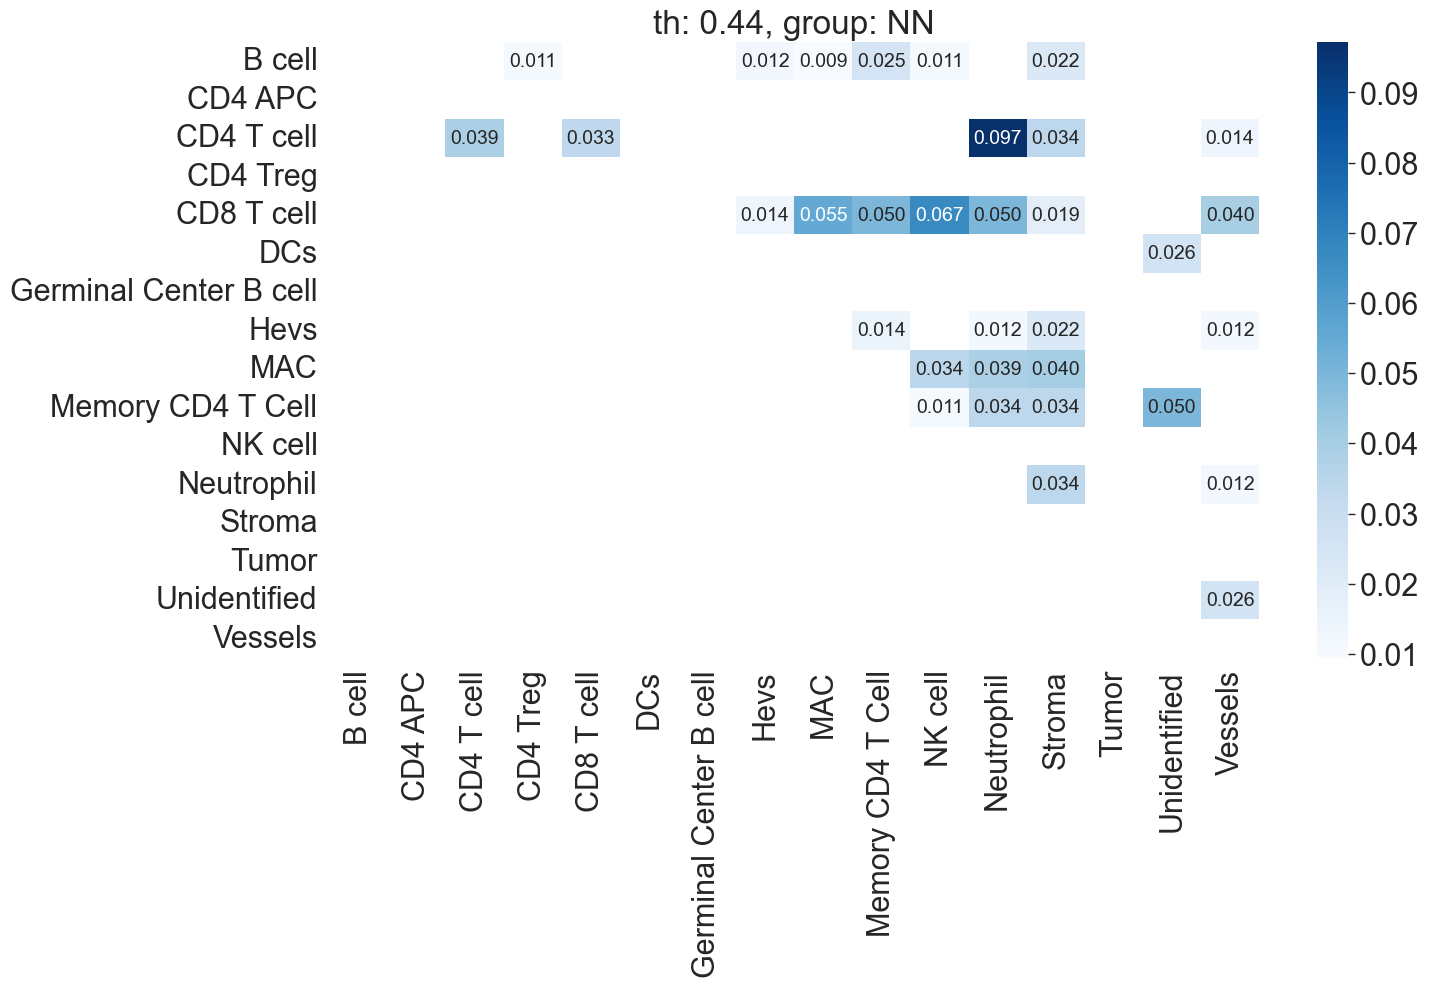

motif_id: 7809321100, hash_id: 6772266359495739224
motif_id: 16939817356, hash_id: 2559706041182080051
motif_id: 16942445964, hash_id: 2559706041182080051
motif_id: 12110603532, hash_id: 2856578561211090970
motif_id: 4065949068, hash_id: 2643836404408428104
motif_id: 16944617868, hash_id: 3774511630474819600
motif_id: 2454267148, hash_id: -2785496978450312591
motif_id: 2961208588, hash_id: 5322849665145976878
motif_id: 1639021836, hash_id: 7476495471272693903
motif_id: 1658451404, hash_id: -3224596876564360443
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 34965962028, hash_id: 1161395837192515596
motif_id: 16416058540, hash_id: 1118968396280097033
motif_id: 15901249932, hash_id: -2937209521203962343
motif_id: 12097480012, hash_id: -5659898672581499462
motif_id: 16417793484, hash_id: 7779624149145954569
motif_id: 3522784716, hash_id: -7428170179511166437
motif_id: 15341317580, hash_id: 6191483428857422447
motif_id: 4880694732, hash_id: 6501729852448164872
motif_id: 53913

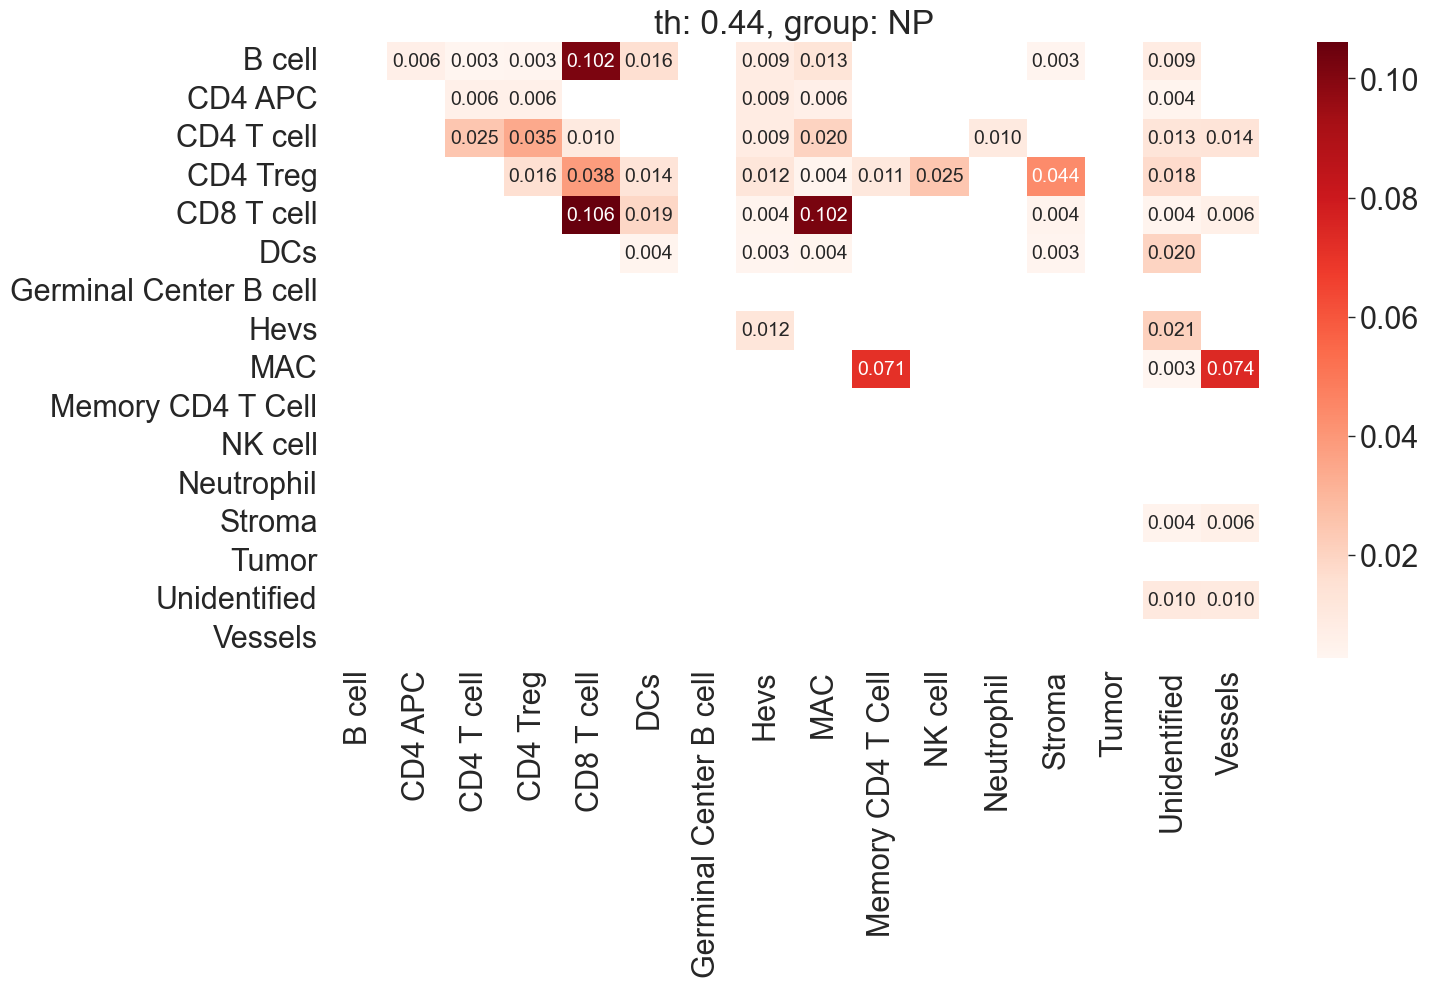

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 8
group NP size: 11
motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 20748339660, hash_id: 7522159845133462507
motif_id: 17763644908, hash_id: -3945035406512623651
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 11583232364, hash_id: -3798811191137981739


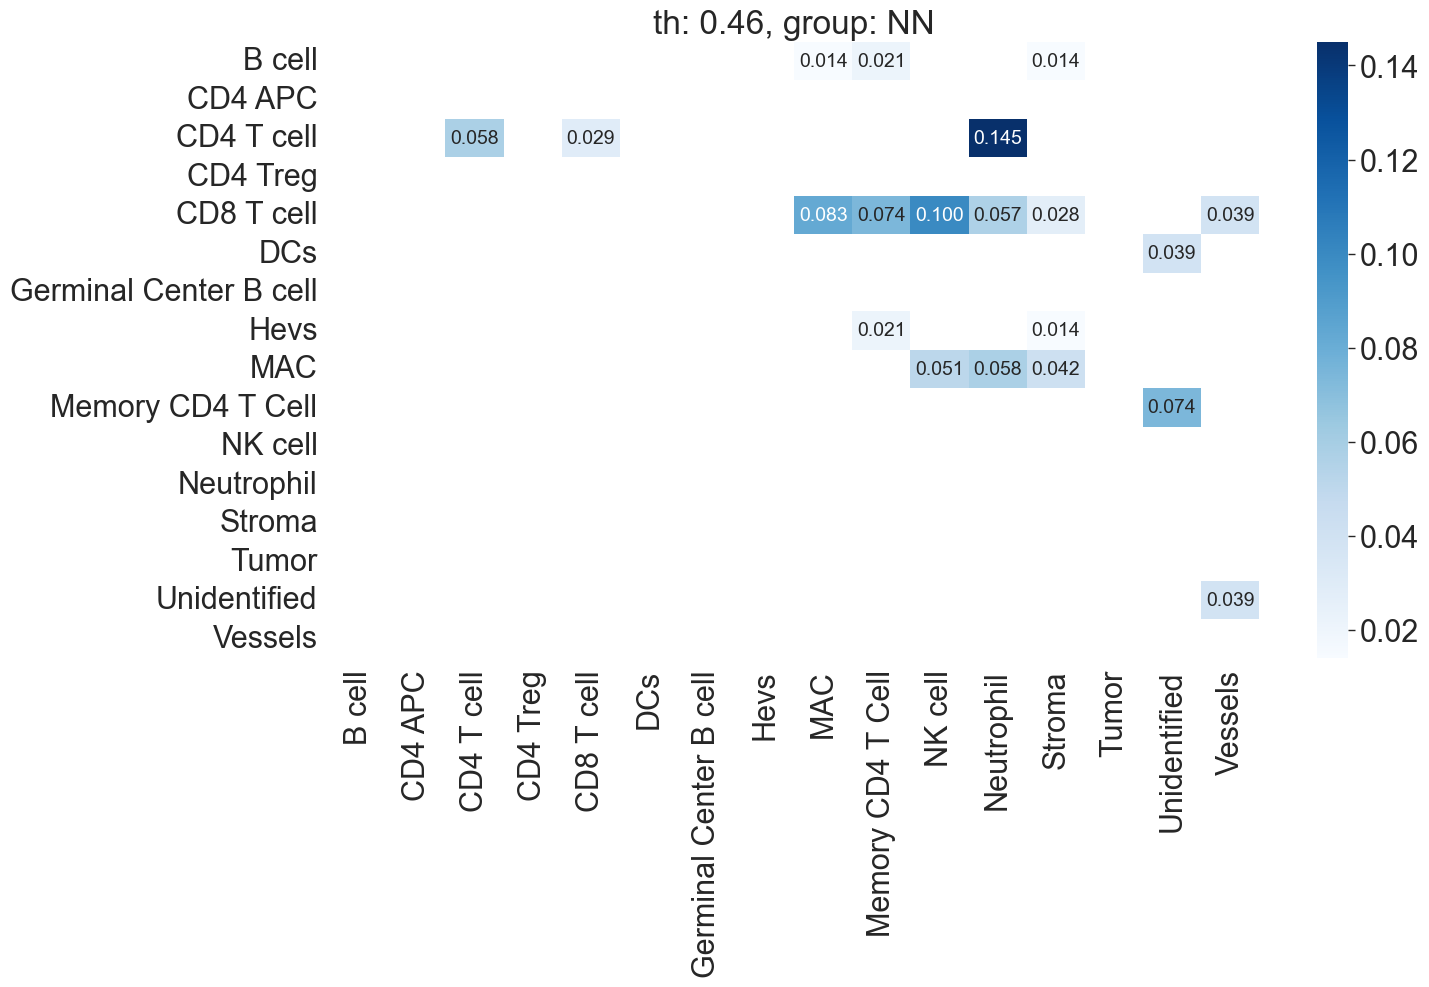

motif_id: 12110603532, hash_id: 2856578561211090970
motif_id: 2454267148, hash_id: -2785496978450312591
motif_id: 2961208588, hash_id: 5322849665145976878
motif_id: 15901249932, hash_id: -2937209521203962343
motif_id: 1639021836, hash_id: 7476495471272693903
motif_id: 4880694732, hash_id: 6501729852448164872
motif_id: 16417793484, hash_id: 7779624149145954569
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 3522784716, hash_id: -7428170179511166437
motif_id: 15341317580, hash_id: 6191483428857422447
motif_id: 11075202540, hash_id: -2419085700876409031


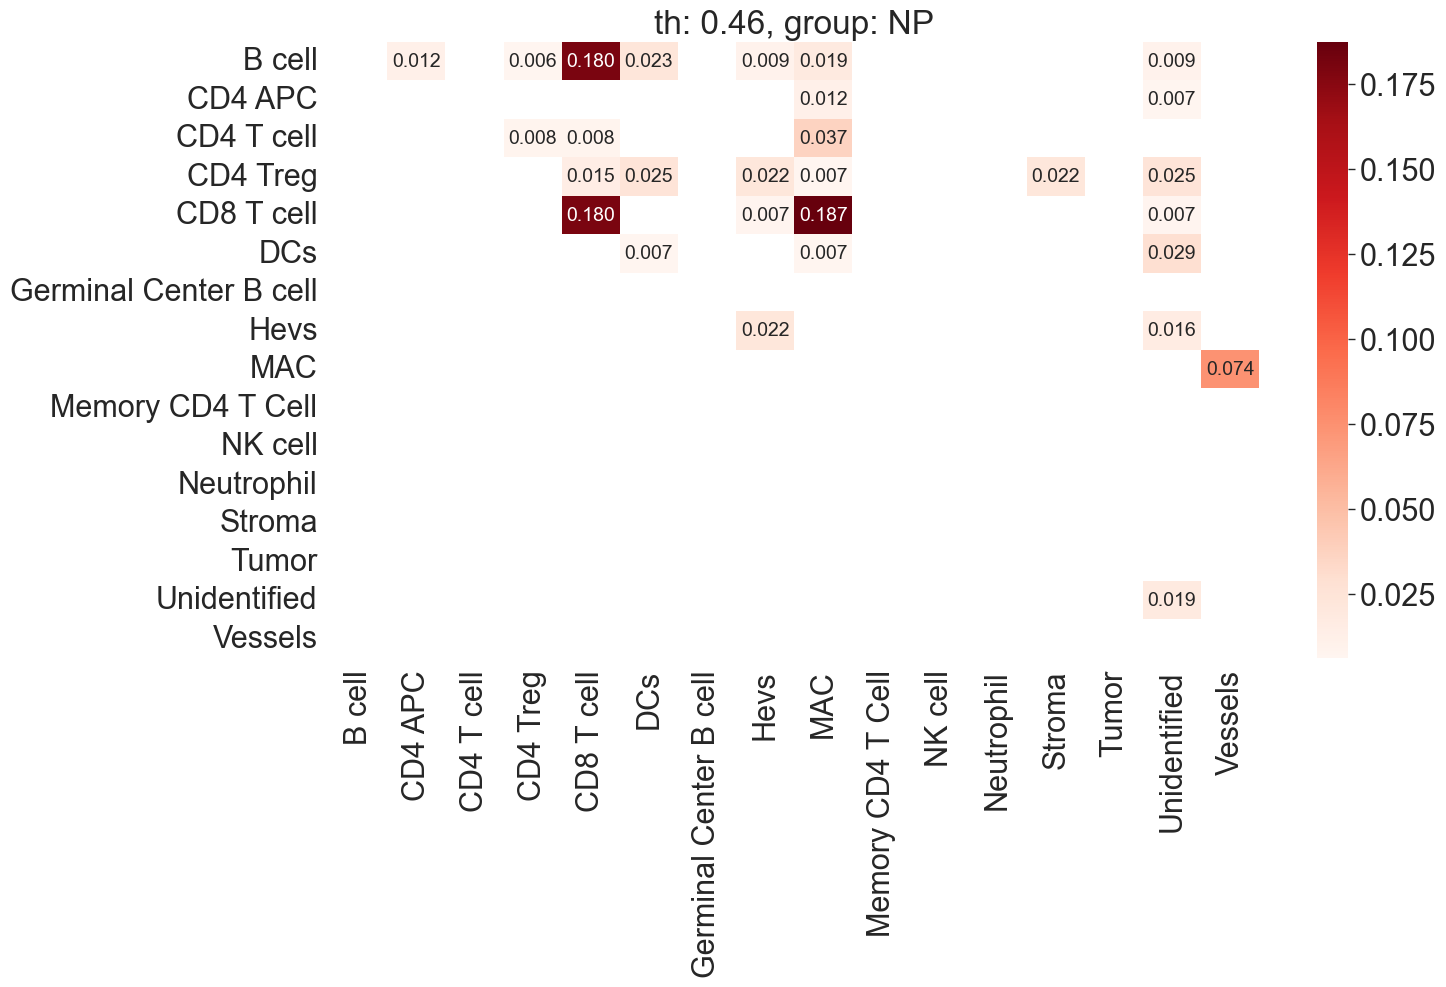

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 7
group NP size: 10
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 11583232364, hash_id: -3798811191137981739
motif_id: 20748339660, hash_id: 7522159845133462507


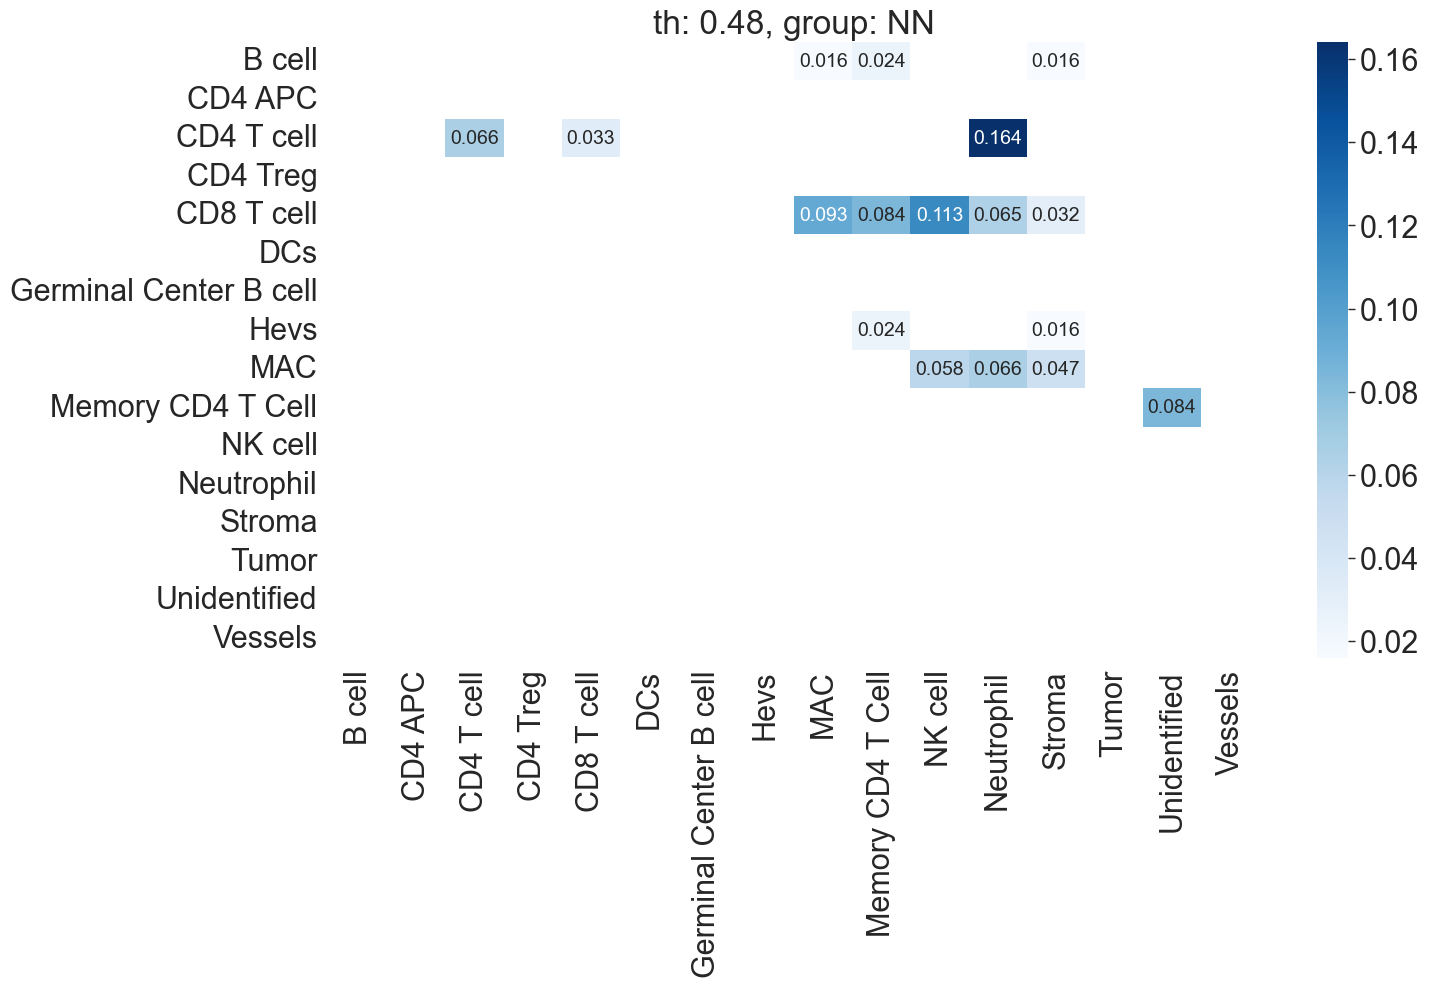

motif_id: 2454267148, hash_id: -2785496978450312591
motif_id: 2961208588, hash_id: 5322849665145976878
motif_id: 1639021836, hash_id: 7476495471272693903
motif_id: 11075202540, hash_id: -2419085700876409031
motif_id: 15901249932, hash_id: -2937209521203962343
motif_id: 4880694732, hash_id: 6501729852448164872
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 3522784716, hash_id: -7428170179511166437
motif_id: 15341317580, hash_id: 6191483428857422447
motif_id: 12110603532, hash_id: 2856578561211090970


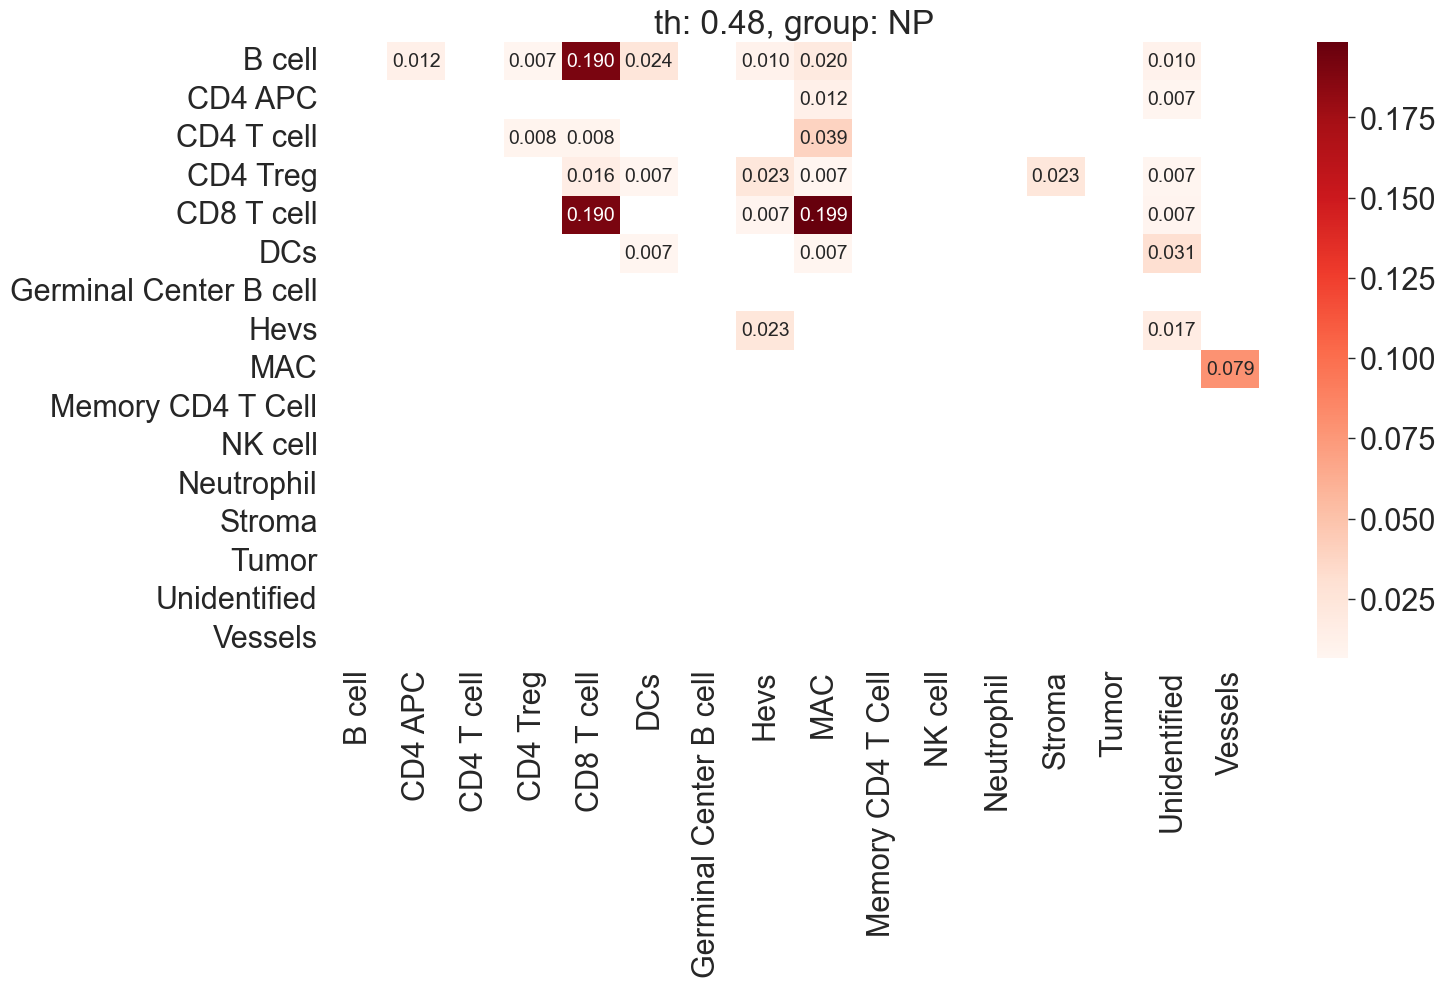

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 2
group NP size: 4
motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 11561745772, hash_id: 3341299229835211946


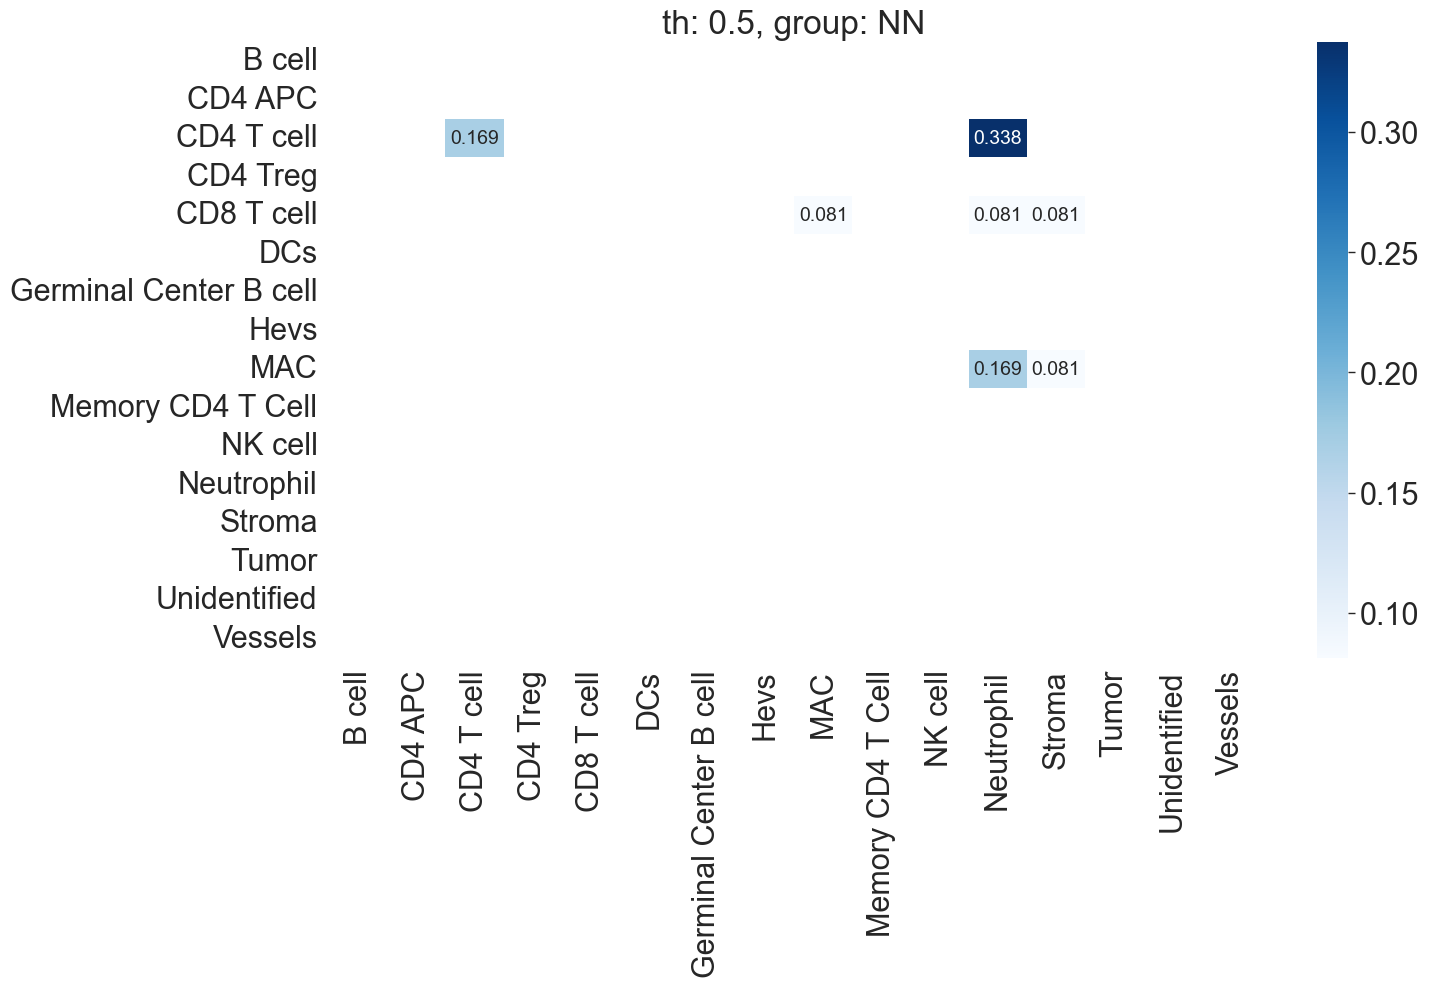

motif_id: 3522784716, hash_id: -7428170179511166437
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 15341317580, hash_id: 6191483428857422447
motif_id: 4880694732, hash_id: 6501729852448164872


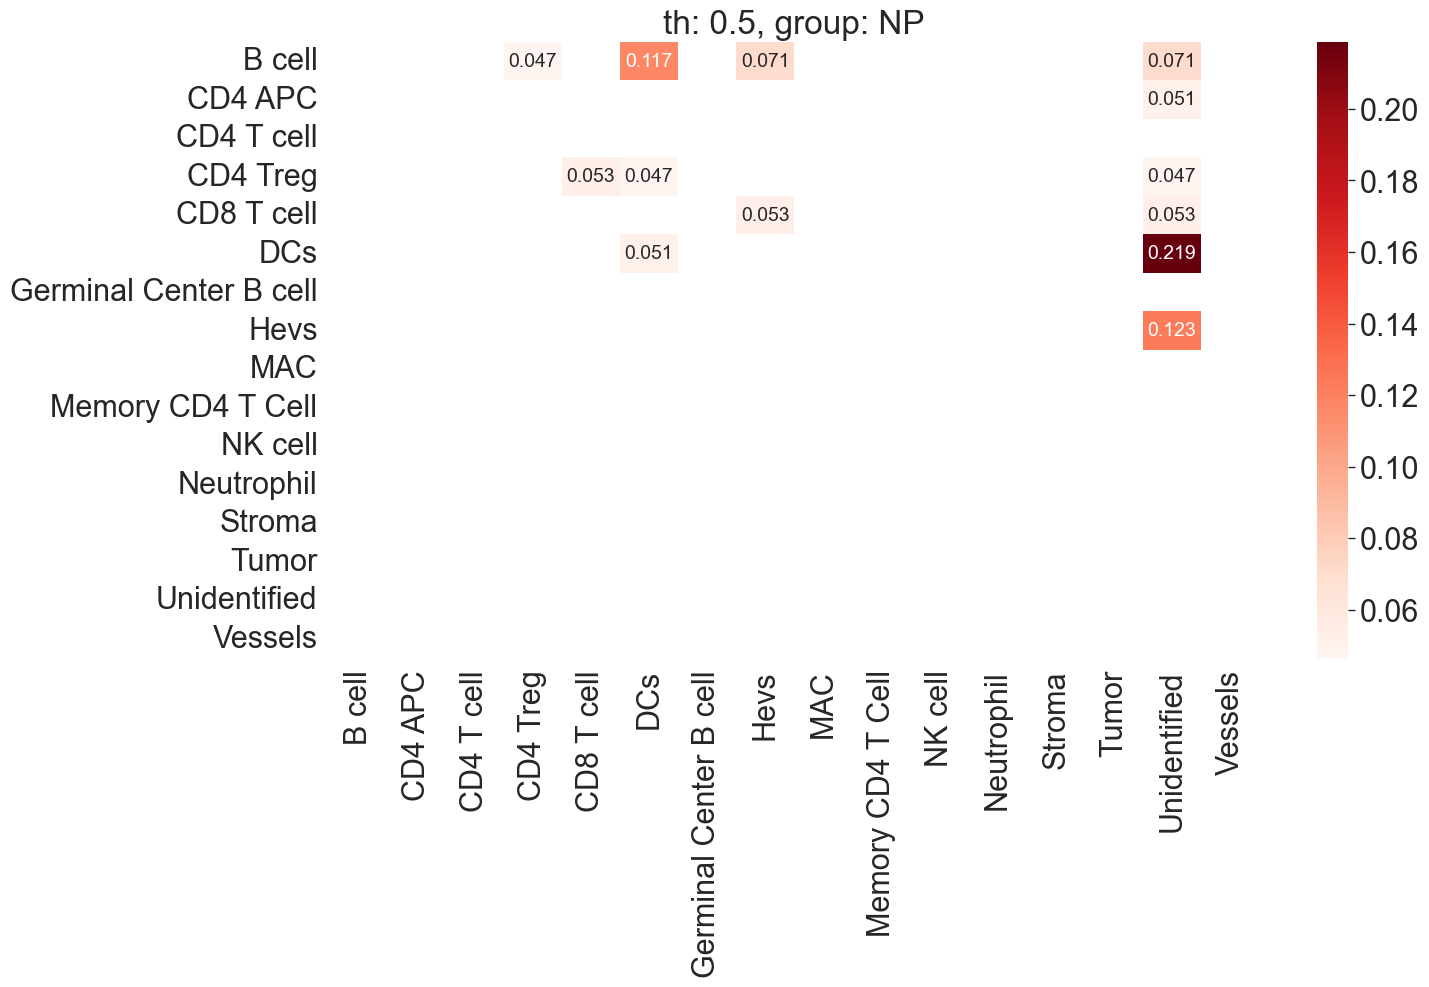

  0%|          | 0/38 [00:00<?, ?it/s]

group NN size: 0
group NP size: 1


All-NaN slice encountered
All-NaN slice encountered


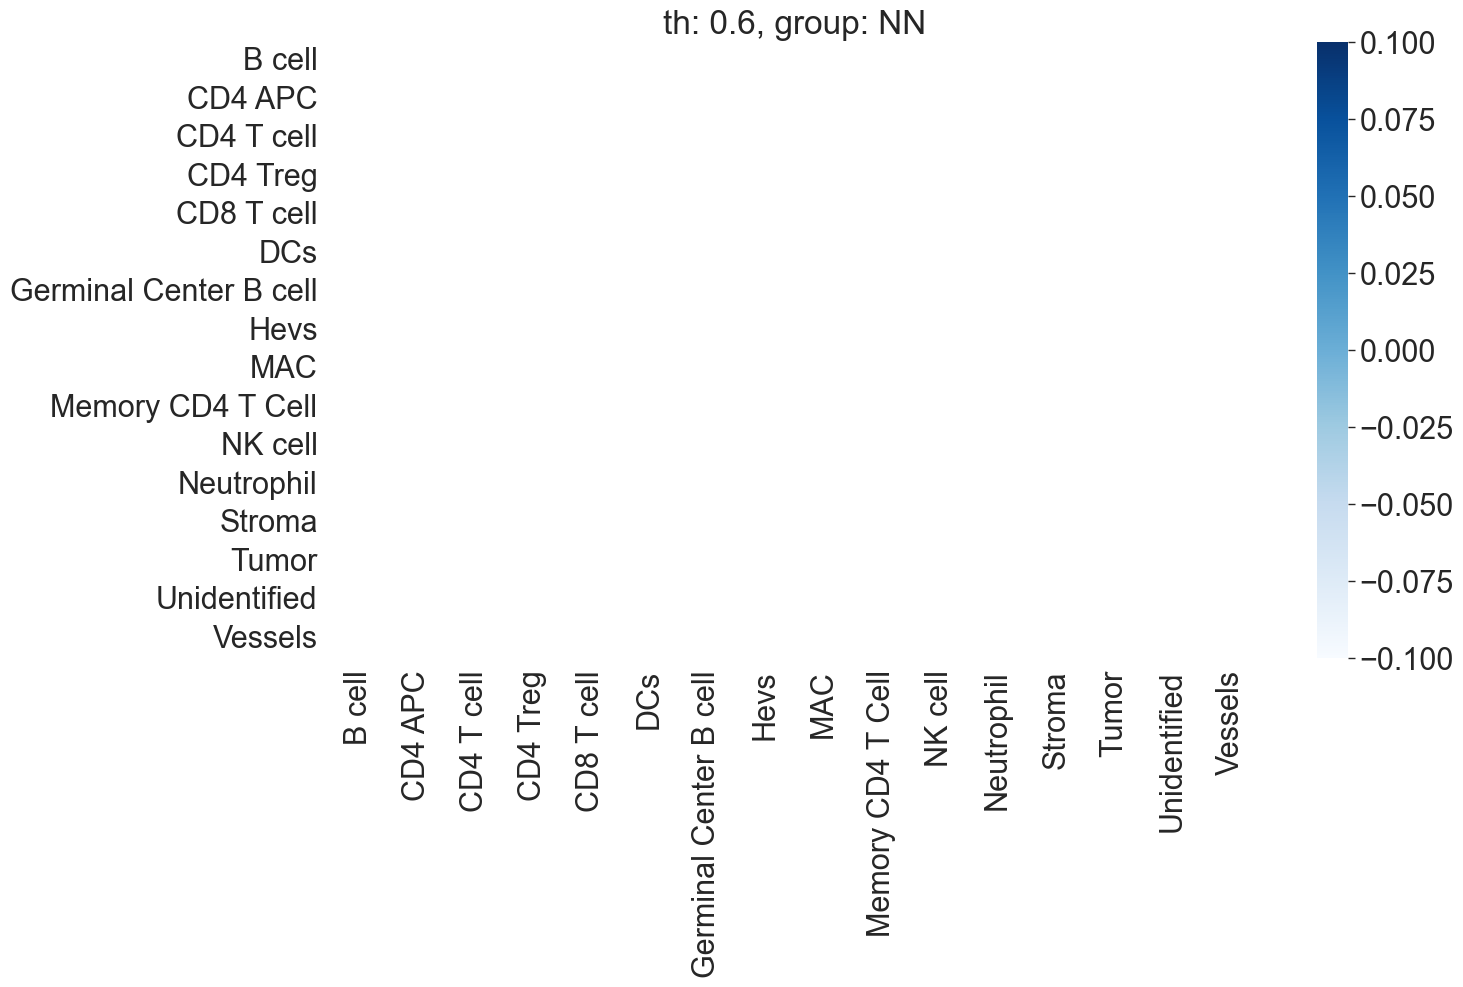

motif_id: 15341317580, hash_id: 6191483428857422447


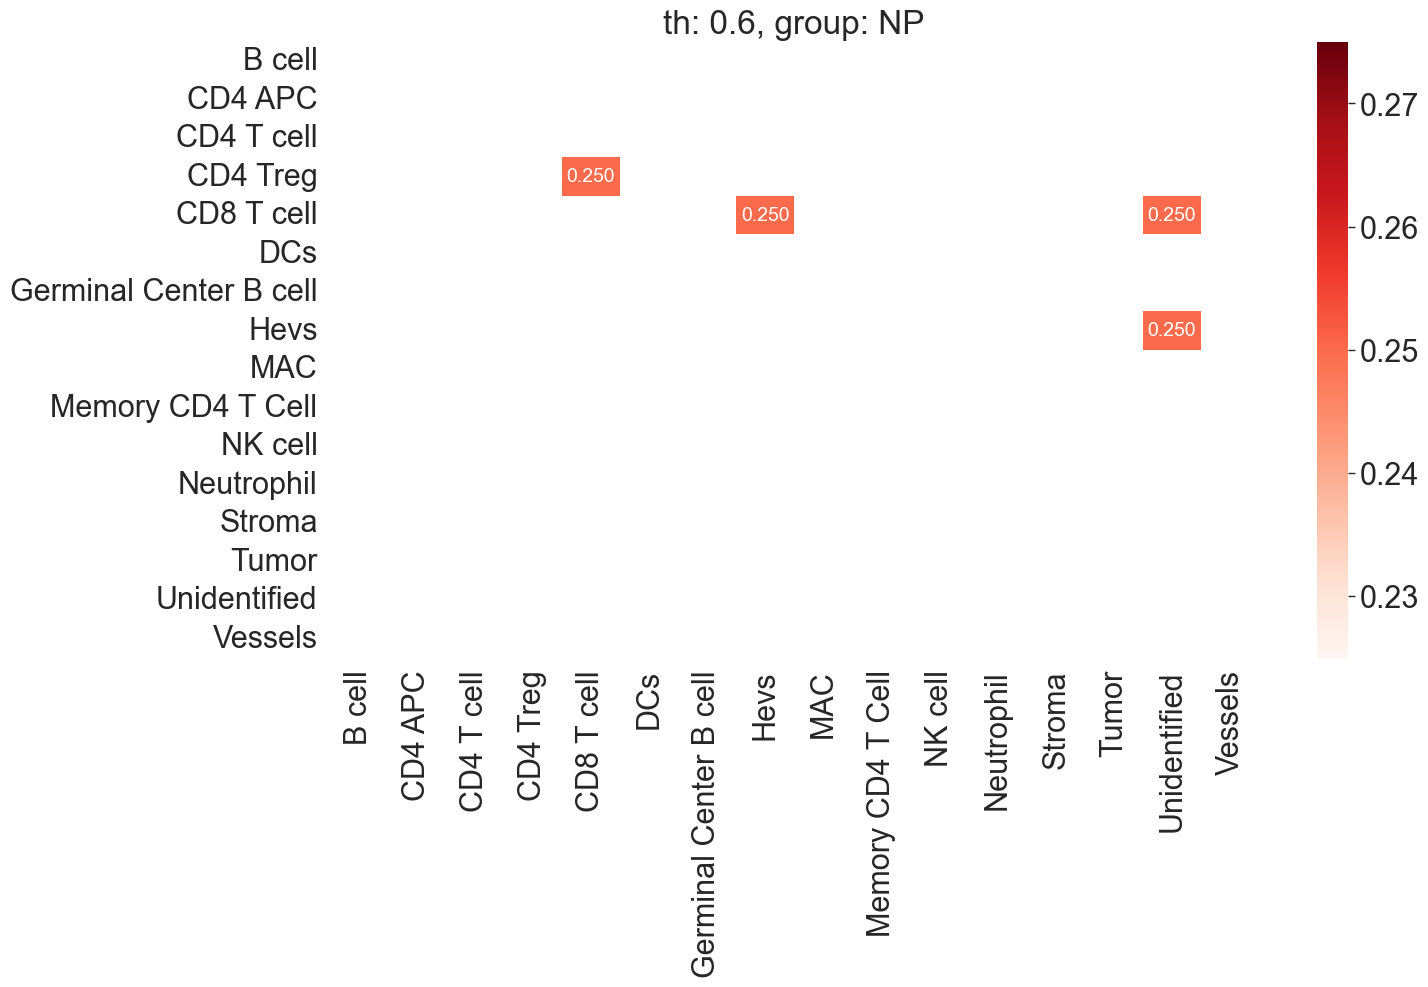

In [7]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC
import seaborn as sns
from matplotlib import pyplot as plt
from cism import helpers

local_motif_size = 4
sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

discriminator.cism.motifs_dataset['Total'] = discriminator.cism.motifs_dataset['Count']/discriminator.cism.motifs_dataset['Freq']

relevant_patients = discriminator.get_patients_class(target_classes)

group_NN = []
group_NP = []

for shared_percentage_th in [0.2, 0.3, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.6]:
    featureConf = HardDiscriminativeFC(
                    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                    use_cells_type_composition=False,
                    use_motifs=True,
                    shared_percentage=shared_percentage_th,
                    max_class_features=30,
                    labels=target_classes)

    motif_space_features = discriminator.get_features(feature_conf=featureConf,
                                                      exclude_patients=[],
                                                      n_jobs=1)

    all_motif_features = []
    for idx, row in motif_space_features.iterrows():
        all_motif_features += row['features']
    all_motif_features = list(set(all_motif_features))

    motif_to_cells_identity_hash = {}
    for motif_id in all_motif_features:
        motif_to_cells_identity_hash[motif_id] = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

    cell_identity_to_motif_hash = {}
    for k, v in motif_to_cells_identity_hash.items():
        cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]


    new_freq_table = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID'], observed=True)[['Count', 'Total']].sum().reset_index()

    new_freq_table['Freq'] = new_freq_table['Count']/new_freq_table['Total']
    motif_mean_count = new_freq_table.groupby('ID')['Freq'].mean()

    group_a_motifs = []
    group_b_motifs = []

    relevant_patients = discriminator.get_patients_class(target_classes)
    for motif_id in all_motif_features:
        patients_ids = discriminator.cism.motifs_dataset[
            (discriminator.cism.motifs_dataset.ID == motif_id) &
            (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
        groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
        counter = Counter(groups_ids)
        if max(counter, key=counter.get) == target_classes[0]:
            group_a_motifs.append(motif_id)
        else:
            group_b_motifs.append(motif_id)

    plt.figure(figsize=(15,8))
    
    print(f'group {target_classes[0]} size: {len(group_a_motifs)}')
    print(f'group {target_classes[1]} size: {len(group_b_motifs)}')

    df = create_weight_matrix_from_motifs(
                        discriminator=discriminator,
                        cells_type=cells_type,
                        cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                        motifs_ids=group_a_motifs,
                        motifs_weight=motif_mean_count)
    group_NN.append(df)
    plt.title(f'th: {shared_percentage_th}, group: {target_classes[0]}')
    ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")
    plt.show()
    plt.close()

    plt.figure(figsize=(15,8))
    df = create_weight_matrix_from_motifs(
                            discriminator=discriminator,
                            cells_type=cells_type,
                            cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                            motifs_ids=group_b_motifs,
                            motifs_weight=motif_mean_count)
    group_NP.append(df)
    plt.title(f'th: {shared_percentage_th}, group: {target_classes[1]}')
    ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Reds', annot_kws={'size': 14}, fmt=".3f")
    plt.show()
    plt.close()

Calculate the correlation between i, i+1 and i, j

In [8]:
from scipy import stats

def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

for i in [0, 1]:
    print(f'index {i}')
    print(stats.spearmanr(upper(group_NN[i]), upper(group_NN[i+1])))
    print(stats.spearmanr(upper(group_NN[i]), upper(group_NP[i])))
    print(stats.spearmanr(upper(group_NP[i]), upper(group_NP[i+1])))

index 0
SignificanceResult(statistic=0.6560759073496647, pvalue=4.1733667786575965e-16)
SignificanceResult(statistic=0.369607549921454, pvalue=3.258999589847356e-05)
SignificanceResult(statistic=0.716768566959256, pvalue=3.393731779409362e-20)
index 1
SignificanceResult(statistic=0.44853090706907034, pvalue=2.7823911212182916e-07)
SignificanceResult(statistic=0.17118193996095338, pvalue=0.06156718549975543)
SignificanceResult(statistic=0.42958438132507093, pvalue=9.771207011233915e-07)


In [9]:
print(stats.spearmanr(upper(group_NN[2]), upper(group_NP[2])))

SignificanceResult(statistic=0.015110867665284827, pvalue=0.8698822921651888)
